Abdomen_Inception classification:

0-SG, 1-G, 2-UF, 3-FF

Author: Remus

In [ ]:
#%load_ext nb_black
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
REBUILD_DATA = False

fileNameStr = "Master Data Sheet Organization.xlsx"
data_df = pd.read_excel(fileNameStr)

<IPython.core.display.Javascript object>

In [ ]:
new_header = data_df.iloc[0]  # grab the first row for the header
data_df = data_df[1:]  # take the data less the header row
data_df.columns = new_header  # set the header row as the df header
data_df.shape

(1722, 18)

<IPython.core.display.Javascript object>

In [ ]:
# delete data without abdomen status
data_df = data_df.dropna(subset=["Abdomen Status"], how="any")
data_df = data_df.loc[(data_df["Picture?"] == "Y")]

<IPython.core.display.Javascript object>

In [ ]:
print("size after deletion", data_df.shape)

size after deletion (799, 18)


<IPython.core.display.Javascript object>

In [ ]:
# reset index
data_df = data_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [ ]:
data_df.head()

,NaN,Country,District,Sentinel Site,Date,MOSQUITO ID (Team),Morph ID Genus,Morph ID Species,PCR Number (Country Specific),PCR ID Genus,PCR ID Species,Sibling Species,Picture?,Prototype,Abdomen Status,Sex,Parity,Eliza Results
0,6.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0006,Anopheles,funestus,498,NaN,NaN,NaN,Y,1409,SG,F,NaN,NaN
1,8.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0008,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,UF,NaN,NaN,NEG
2,9.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0009,Anopheles,funestus,NaN,NaN,NaN,NaN,Y,NaN,G,F,NaN,NEG
3,10.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0010,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,G,F,NaN,NEG
4,12.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0012,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,FF,NaN,NaN,NEG


<IPython.core.display.Javascript object>

In [ ]:
# selecting rows based on condition
df1 = data_df.loc[(data_df["Abdomen Status"] == "SG")]
df2 = data_df.loc[(data_df["Abdomen Status"] == "G")]
df3 = data_df.loc[(data_df["Abdomen Status"] == "FF")]
df4 = data_df.loc[(data_df["Abdomen Status"] == "UF")]
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(63, 18)
(76, 18)
(163, 18)
(481, 18)


<IPython.core.display.Javascript object>

In [ ]:
df1.head()

,NaN,Country,District,Sentinel Site,Date,MOSQUITO ID (Team),Morph ID Genus,Morph ID Species,PCR Number (Country Specific),PCR ID Genus,PCR ID Species,Sibling Species,Picture?,Prototype,Abdomen Status,Sex,Parity,Eliza Results
0,6.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0006,Anopheles,funestus,498,NaN,NaN,NaN,Y,1409,SG,F,NaN,NaN
6,14.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0014,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,SG,F,NaN,NEG
16,26.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0026,Anopheles,gambiae,NaN,Anopheles,gambiae,ss,Y,NaN,SG,F,NaN,NEG
20,30.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0030,Anopheles,gambiae,NaN,NaN,NaN,NaN,Y,NaN,SG,F,NaN,NaN
21,34.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0034,Anopheles,funestus,NaN,Anopheles,gambiae,arabiensis,Y,NaN,SG,F,NaN,NEG


<IPython.core.display.Javascript object>

In [ ]:
# one train and test split
from sklearn.model_selection import train_test_split

train_data1, test_data1 = train_test_split(df1, test_size=0.2)
train_data2, test_data2 = train_test_split(df2, test_size=0.2)
train_data3, test_data3 = train_test_split(df3, test_size=0.2)
train_data4, test_data4 = train_test_split(df4, test_size=0.2)

<IPython.core.display.Javascript object>

In [ ]:
train_data = pd.concat(
    [train_data1, train_data2, train_data3, train_data4], ignore_index=True
)
test_data = pd.concat(
    [test_data1, test_data2, test_data3, test_data4], ignore_index=True
)
print(train_data.shape)
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

(624, 18)


<IPython.core.display.Javascript object>

In [ ]:
train_data.head()

,NaN,Country,District,Sentinel Site,Date,MOSQUITO ID (Team),Morph ID Genus,Morph ID Species,PCR Number (Country Specific),PCR ID Genus,PCR ID Species,Sibling Species,Picture?,Prototype,Abdomen Status,Sex,Parity,Eliza Results
0,1625.0,Zambia,Matcha,B2,2021-04-29 00:00:00,Z-MA-01-0274,Anopheles,rufipes,MI2100274,NaN,NaN,NaN,Y,NaN,UF,F,NaN,NaN
1,1509.0,Zambia,Matcha,B1,2021-02-14 00:00:00,Z-MA-01-0158,Anopheles,squamosus,MI2100158,NaN,NaN,NaN,Y,NaN,UF,F,NaN,NaN
2,1602.0,Zambia,Matcha,Chidakwa,2021-02-14 00:00:00,Z-MA-01-0251,Anopheles,squamosus,MI2100251,Anopheles,squamosus,NaN,Y,NaN,UF,F,NaN,NaN
3,204.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0204,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,UF,NaN,NaN,NEG
4,359.0,Uganda,Soroti,Awoja,2021-08-15 00:00:00,U-SR-01-0359,Mansonia,NaN,NaN,NaN,NaN,NaN,Y,NaN,UF,NaN,NaN,NEG


<IPython.core.display.Javascript object>

In [ ]:
test_data.head()


,NaN,Country,District,Sentinel Site,Date,MOSQUITO ID (Team),Morph ID Genus,Morph ID Species,PCR Number (Country Specific),PCR ID Genus,PCR ID Species,Sibling Species,Picture?,Prototype,Abdomen Status,Sex,Parity,Eliza Results
0,547.0,Uganda,Soroti,Awoja,2021-08-14 00:00:00,U-SR-01-0547,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,UF,NaN,NaN,NEG
1,1500.0,Zambia,Matcha,Chidakwa,2021-02-11 00:00:00,Z-MA-01-0149,Anopheles,squamosus,MI2100149,NaN,NaN,NaN,Y,NaN,FF,F,NaN,NaN
2,475.0,Uganda,Soroti,Awoja,2021-08-13 00:00:00,U-SR-01-0475,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,UF,NaN,NaN,NEG
3,1568.0,Zambia,Matcha,B2,2021-02-14 00:00:00,Z-MA-01-0217,Anopheles,gambiae,MI2100217,Anopheles,gambiae,arabiensis,Y,NaN,UF,F,NaN,NaN
4,283.0,Uganda,Soroti,Awoja,2021-08-16 00:00:00,U-SR-01-0283,Anopheles,funestus,NaN,Anopheles,funestus,ss,Y,NaN,SG,F,NaN,NEG


<IPython.core.display.Javascript object>

In [ ]:
from torchvision import transforms

mosquito_transforms = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.Resize([299, 299]),
        transforms.ToTensor(),
    ]
)

<IPython.core.display.Javascript object>

In [ ]:
from PIL import Image

# read data function
def make_data(d):
    data_path = "Mosquito_Database_Rev2"
    data = []
    label = []
    paths = []
    df = pd.DataFrame()
    UF_count = 0
    FF_count = 0
    SG_count = 0
    G_count = 0
    for i in range(d.shape[0]):
        for f in os.listdir(data_path):
            if re.match(d.loc[i, "MOSQUITO ID (Team)"], f) and f.endswith("a.jpg"):
                path = os.path.join(data_path, f)
                paths.append(path)
                image = Image.open(path)
                image = mosquito_transforms(image)
                data.append(image)
                if d.loc[i, "Abdomen Status"] == "SG":
                    label.append(0)
                    SG_count += 1
                if d.loc[i, "Abdomen Status"] == "G":
                    label.append(1)
                    G_count += 1
                if d.loc[i, "Abdomen Status"] == "UF":
                    label.append(2)
                    UF_count += 1
                if d.loc[i, "Abdomen Status"] == "FF":
                    label.append(3)
                    FF_count += 1
    stacked_data = torch.stack(data)
    df["path"] = paths
    df["label"] = label

    return stacked_data, label, df, UF_count, FF_count, SG_count, G_count

<IPython.core.display.Javascript object>

In [ ]:
data, label, paths, UF_count, FF_count, SG_count, G_count = make_data(test_data)

<IPython.core.display.Javascript object>

In [ ]:
print(data.shape)
print(UF_count)
print(FF_count)
print(SG_count)
print(G_count)

torch.Size([341, 3, 299, 299])
142
103
43
53


<IPython.core.display.Javascript object>

In [ ]:
print("Test min=%.3f, max=%.3f" % (np.array(data).min(), np.array(data).max()))

Test min=0.000, max=0.953


<IPython.core.display.Javascript object>

In [ ]:
torch.save(data, "abdomen/data/test_data.pt")
torch.save(torch.tensor(label), "abdomen/data/test_label.pt")
paths.to_csv("abdomen/data/test_path.csv", index=False)

<IPython.core.display.Javascript object>

In [ ]:
data2, label2, paths2, UF_count2, FF_count2, SG_count2, G_count2 = make_data(train_data)

<IPython.core.display.Javascript object>

In [ ]:
print(data2.shape)
print(UF_count2)
print(FF_count2)
print(SG_count2)
print(G_count2)

torch.Size([1447, 3, 299, 299])
670
414
170
193


<IPython.core.display.Javascript object>

In [ ]:
print("Test min=%.3f, max=%.3f" % (np.array(data2).min(), np.array(data2).max()))

Test min=0.000, max=0.953


<IPython.core.display.Javascript object>

In [ ]:
torch.save(data2, "abdomen/data/train_data.pt")
torch.save(torch.tensor(label2), "abdomen/data/train_label.pt")
paths2.to_csv("abdomen/data/train_path.csv", index=False)

<IPython.core.display.Javascript object>

In [ ]:
train_data = torch.load("drive/MyDrive/VectorCam_Abdomen/train_data.pt")
train_label = torch.load("drive/MyDrive/VectorCam_Abdomen/train_label.pt")
test_data = torch.load("drive/MyDrive/VectorCam_Abdomen/test_data.pt")
test_label = torch.load("drive/MyDrive/VectorCam_Abdomen/test_label.pt")

In [ ]:
train_data = torch.load("drive/MyDrive/addomen test/train_data_4.pt")
train_label = torch.load("drive/MyDrive/addomen test/train_label_4.pt")
test_data = torch.load("drive/MyDrive/addomen test/test_data_4.pt")
test_label = torch.load("drive/MyDrive/addomen test/test_label_4.pt")

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

torch.Size([1191, 3, 299, 299])
torch.Size([292, 3, 299, 299])
torch.Size([1191])
torch.Size([292])


In [ ]:
from torchvision.transforms.transforms import RandomAdjustSharpness
from torchvision import transforms

mosquito_transforms_train = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.Resize([299,299]),
        # transforms.ToTensor(),
        # transforms.RandomRotation(degrees=(180)),
        #transforms.RandomHorizontalFlip(p=0.25),
        #transforms.RandomVerticalFlip(p=0.25),
        #transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.Normalize((0.6108, 0.6396, 0.6583), (0.1050, 0.0863, 0.0887))
    ]
)

In [ ]:
mosquito_transforms_test = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.Resize([299,299]),
        # transforms.ToTensor(),
    ]
)

In [ ]:
from torch.utils.data import Dataset


class VectorCamDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        "Initialization"
        self.labels = labels
        self.data = data
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.data)

    def __getitem__(self, index):

        "Generates one sample of data"

        # Load data and get label
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        y = self.labels[index]

        return x, y

In [ ]:
train_dataset = VectorCamDataset(train_data, train_label)#, mosquito_transforms_train)
test_dataset = VectorCamDataset(test_data, test_label)#, mosquito_transforms_test)

In [ ]:
x, y = train_dataset[3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


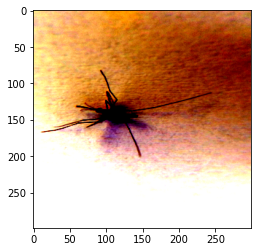

In [ ]:
plt.imshow(torch.permute(train_dataset[14][0], (1, 2, 0)))

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

target_list = torch.tensor(train_dataset.labels)
print(target_list.shape)
class_count = np.array(
    [
        len(np.where(train_dataset.labels == t)[0])
        for t in np.unique(train_dataset.labels)
    ]
)
print(class_count)
class_weights = 1.0 / torch.tensor(class_count, dtype=torch.float)
print(class_weights)
class_weights_all = class_weights[target_list]
print(class_weights_all.shape)
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all, num_samples=len(class_weights_all)
)

torch.Size([1191])
[167 196 396 432]
tensor([0.0060, 0.0051, 0.0025, 0.0023])
torch.Size([1191])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_dataloader = DataLoader(train_dataset, sampler=weighted_sampler, batch_size=32)
# valid_dataloader = DataLoader(valid_dataset ,batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the cpu")

running on the GPU


# Train and test

In [ ]:
from torchvision import models

model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(2048, 5)
model.AuxLogits.fc = nn.Linear(768, 5)
model.load_state_dict(torch.load("drive/MyDrive/VectorCam_Abdomen/pretrain_Inception.pt"))
model.fc = nn.Linear(2048, 4)
model.AuxLogits.fc = nn.Linear(768, 4)
model = model.to(device)

In [ ]:
# if want to load trained model
model = torch.load("drive/MyDrive/VectorCam_Abdomen/Abdomen_Inception.pt")

In [ ]:
print(model)

In [ ]:
# convert .pt to .ptl
# no need to run during training and testing
model.eval()
model.cpu()
from torch.utils.mobile_optimizer import optimize_for_mobile
example = torch.rand(1, 3, 299, 299)
traced_script_module = torch.jit.trace(model, example)
optimized_scripted_module = optimize_for_mobile(traced_script_module)
optimized_scripted_module._save_for_lite_interpreter("drive/MyDrive/VectorCam_Abdomen/Abdomen_Inception.ptl")

In [ ]:
# hyperparameters 
EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

In [ ]:
# one of the losses could try
def focal_loss(inputs, targets, reduction="mean"):
    CE_loss = F.cross_entropy(inputs, targets, reduction=reduction)
    pt = torch.exp(-CE_loss)  # prevents nans when probability 0
    F_loss = 0.25 * (1 - pt) ** 5 * CE_loss
    return F_loss.mean()

<IPython.core.display.Javascript object>

In [ ]:
def train(model):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range(EPOCHS + 1):

        correct = 0
        total = 0
        train_ave_loss = 0
        model.train()
        for batch_X, batch_Y in train_dataloader:

            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            # zero gradient
            optimizer.zero_grad()
            # pass through
            outputs, aux_outputs = model(batch_X)

            # compute loss and back propagate
            loss1 = criterion(outputs, batch_Y)
            loss2 = criterion(aux_outputs, batch_Y)
            loss = loss1 + 0.4 * loss2

            loss.backward()
            # optimize
            optimizer.step()

            train_ave_loss += loss.data.item()
            _, predicted = outputs.max(1)
            total += batch_Y.size(0)
            correct += predicted.eq(batch_Y).sum().item()

        train_loss.append(train_ave_loss / len(train_dataloader))
        train_acc.append(100.0 * correct / total)
        print(
            f"Epoch: {epoch}, loss: {train_ave_loss/len(train_dataloader)} | acc: {100.*correct/total} ({correct}/{total})"
        )

        if epoch % 1 == 0:

            model.eval()
            valid_correct = 0
            valid_total = 0
            valid_ave_loss = 0
            with torch.no_grad():

                for valid_batch_X, valid_batch_Y in test_dataloader:

                    valid_batch_X = valid_batch_X.to(device)
                    valid_batch_Y = valid_batch_Y.to(device)

                    valid_outputs = model(valid_batch_X)
                    loss = criterion(valid_outputs, valid_batch_Y)
                    valid_ave_loss += loss.data.item()

                    _, predicted = valid_outputs.max(1)

                    valid_correct += predicted.eq(valid_batch_Y).sum().item()
                    valid_total += valid_batch_Y.size(0)

            valid_loss.append(valid_ave_loss / len(test_dataloader))
            valid_acc.append(100.0 * valid_correct / valid_total)

            print(
                f" valid_loss: {valid_ave_loss/len(test_dataloader)} | valid_acc: {100.*valid_correct/valid_total} ({valid_correct}/{valid_total})"
            )
            # torch.save(model.state_dict(), \
            #   'drive/MyDrive/pretrain_data_path/pretrain_Inception{}.pt'.format(str(epoch//1+2)))

        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc


def test(model):
    correct = 0
    total = 0
    model.eval()
    out = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # loss = criterion(outputs, test_y[i].to(device).long())
            _, predicted = outputs.max(1)
            out.append(predicted.cpu().detach().numpy())

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    print("Accuracy:", round(correct / total, 3))
    return out

In [ ]:
train_loss, valid_loss, train_acc, valid_acc = train(model)

Epoch: 0, loss: 1.4116970661439394 | acc: 56.507136859781696 (673/1191)
 valid_loss: 1.2476016283035278 | valid_acc: 48.28767123287671 (141/292)
Epoch: 1, loss: 0.6132306111486334 | acc: 85.05457598656591 (1013/1191)
 valid_loss: 1.5352416574954986 | valid_acc: 45.54794520547945 (133/292)
Epoch: 2, loss: 0.29981648020054164 | acc: 94.29051217464315 (1123/1191)
 valid_loss: 1.6498993173241616 | valid_acc: 52.73972602739726 (154/292)
Epoch: 3, loss: 0.1803358806003081 | acc: 97.06129303106633 (1156/1191)
 valid_loss: 1.7097501434385776 | valid_acc: 58.21917808219178 (170/292)


KeyboardInterrupt: ignored

In [ ]:
out = test(model)

Accuracy: 0.514


In [ ]:
out = np.concatenate(out).ravel()

In [ ]:
out

array([1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 0, 0, 0,
       0, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       0, 1, 1, 2, 1, 1, 2, 3, 1, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2,
       3, 2, 0, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 2, 3, 3, 3, 3,
       2, 2, 2, 3, 3, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 1, 2, 1,
       1, 1, 3, 3, 3, 2, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3,
       2, 3, 3, 1, 0, 0, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 3, 3, 0, 1, 3, 3, 0, 2, 1, 2, 2, 2, 3, 2, 3, 3, 3, 3, 1,
       1, 0, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

              precision    recall  f1-score   support

           0       0.19      0.33      0.24        43
           1       0.36      0.45      0.40        53
           2       0.79      0.75      0.77       142
           3       0.66      0.43      0.52       103

    accuracy                           0.55       341
   macro avg       0.50      0.49      0.48       341
weighted avg       0.61      0.55      0.57       341



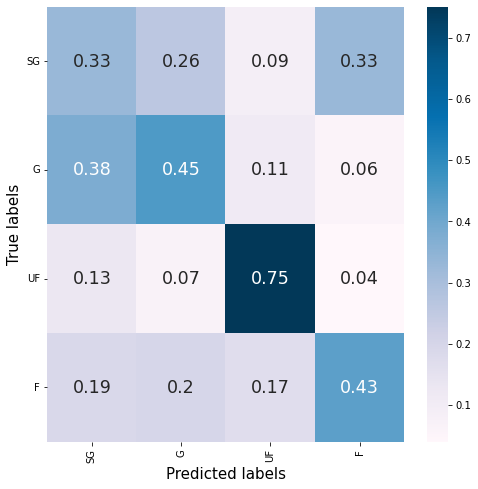

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
species_all = ["SG",
        "G",
        "UF",
        "F"]
# print classification report
print(classification_report(test_label, out))

# make confusion matrix
conf_mat = confusion_matrix(test_label, out)
conf_mat = conf_mat / np.expand_dims(conf_mat.astype(np.float64).sum(axis=1),1)
conf_mat = np.round(conf_mat, decimals=2)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
ax.xaxis.set_ticklabels(species_all); ax.yaxis.set_ticklabels(species_all)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
#plt.savefig('/figures/Species_Inception_fold3.jpg')
plt.show();


# Some visualizations

In [ ]:
misclassified_index = [i for i in range(len(out)) if out[i] != test_label[i]]
print(misclassified_index)

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 62, 66, 67, 68, 70, 71, 73, 75, 79, 80, 81, 82, 83, 86, 87, 96, 97, 98, 99, 100, 101, 102, 110, 112, 117, 118, 119, 123, 124, 125, 126, 128, 138, 140, 145, 146, 147, 152, 156, 157, 158, 160, 162, 166, 167, 168, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 193, 194, 195, 196, 197, 199, 200, 202, 203, 216, 217, 218, 219, 223, 224, 225, 226, 227, 228, 235, 236, 237, 238, 239, 240, 241, 245, 246, 248, 251, 253, 257, 259, 260, 261, 262, 263, 264, 265, 266, 280]


0: SG, 1: G, 2: UF, 3:FF
true label 0  predicted label 3


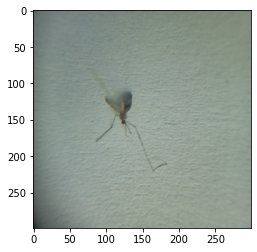

In [ ]:
plt.imshow(torch.permute(test_dataset[6][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[6][1]), " predicted label", out[6])

0: SG, 1: G, 2: UF, 3:FF
true label 0  predicted label 3


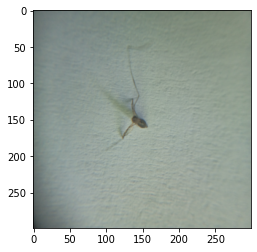

In [ ]:
plt.imshow(torch.permute(test_dataset[7][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[7][1]), " predicted label", out[7])

0: SG, 1: G, 2: UF, 3:FF
true label 0  predicted label 3


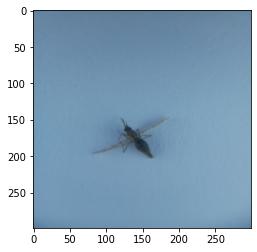

In [ ]:
plt.imshow(torch.permute(test_dataset[9][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[9][1]), " predicted label", out[9])

0: SG, 1: G, 2: UF, 3:FF
true label 0  predicted label 3


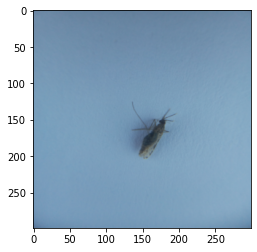

In [ ]:
plt.imshow(torch.permute(test_dataset[10][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[10][1]), " predicted label", out[10])

0: SG, 1: G, 2: UF, 3:FF
true label 1  predicted label 3


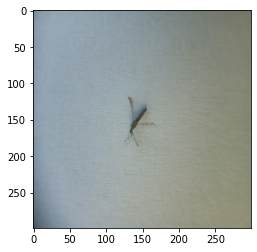

In [ ]:
plt.imshow(torch.permute(test_dataset[15][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[15][1]), " predicted label", out[15])

0: SG, 1: G, 2: UF, 3:FF
true label 3  predicted label 0


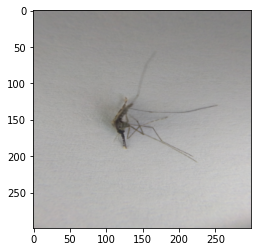

In [ ]:
plt.imshow(torch.permute(test_dataset[35][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[35][1]), " predicted label", out[35])

0: SG, 1: G, 2: UF, 3:FF
true label 2  predicted label 3


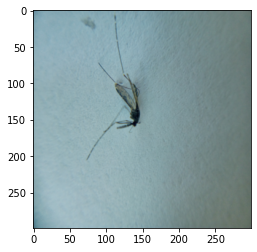

In [ ]:
plt.imshow(torch.permute(test_dataset[40][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[40][1]), " predicted label", out[40])

0: SG, 1: G, 2: UF, 3:FF
true label 2  predicted label 3


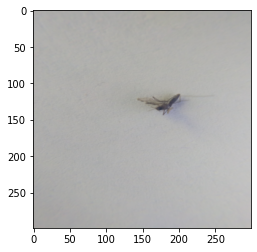

In [ ]:
plt.imshow(torch.permute(test_dataset[160][0], (1, 2, 0)))
print( "0: SG, 1: G, 2: UF, 3:FF")
print("true label", int(test_dataset[160][1]), " predicted label", out[160])

In [ ]:
torch.save(model, 'drive/MyDrive/VectorCam_Abdomen/species_model_testing.pt')

# Calculate mean and std

In [ ]:
# if we want to use our dataset's mean and std
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_and_std(train_dataloader)

In [ ]:
print("mean ", mean)
print("std ", std)

mean  tensor([0.6108, 0.6396, 0.6583])
std  tensor([0.1047, 0.0860, 0.0888])


In [ ]:
for i, (data, target) in enumerate(train_dataloader):
    print(
        "batch index {}, 0/1: {}/{}/{}/{}".format(
            i,
            len(np.where(target.numpy() == 0)[0]),
            len(np.where(target.numpy() == 1)[0]),
            len(np.where(target.numpy() == 2)[0]),
            len(np.where(target.numpy() == 3)[0]),
        )
    )

# Try to have preprosseing inside the model

In [ ]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as T
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.load("drive/MyDrive/VectorCam_Abdomen/Abdomen_Inception.pt")
        self.model.eval()
        self.model.cpu()
        self.transforms = nn.Sequential(
        T.Resize([299, 299]),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        )
    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.model(x)
            return y_pred.argmax(dim=1)